<a href="https://colab.research.google.com/github/fausto1364/age-estimation/blob/main/age_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Age estimation using AlexNet based architecture

In [1]:
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import uuid

# image manipulation
from PIL import Image

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

In [2]:
# mount drive to access APPA-REAL
from google.colab import drive
drive.mount('/content/drive')

path='/content/drive/MyDrive/appa-real-release/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# just to store comands for Image...
'''image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))
image.show()
print(image.format)
print(image.mode)
print(image.size)
test = image.resize((64,64))
test.show()'''

"image = Image.open(os.path.join(path,'005612.jpg_face.jpg'))\nimage.show()\nprint(image.format)\nprint(image.mode)\nprint(image.size)\ntest = image.resize((64,64))\ntest.show()"

In [3]:
# extracts only face detected jpegs. Then rescales size of image and converts to numpy matrix
def preprocess(folder_path,size):
  X=[] # contains processed images
  y=[] # contains ids of images
  # regular expression pattern to only extract files with face detection
  pattern = r"\d+\.jpg_face\.jpg"

  # Loop over all files in the folder
  for imagename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, imagename)
    
    if re.match(pattern, imagename):
      image = Image.open(image_path)
      image = image.resize(size)
      array = [[np.float32(value) for value in row] for row in image.getdata()]
      X.append(np.array(array).reshape(image.size[1], image.size[0], 3))
      y.append(imagename.split(".")[0])
  return X,y

In [4]:
# read the csv files with the apparent ages
def get_appaages(path):
  id = []
  appa_age = []

  # Read the CSV file
  with open(path, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    
    # Skip header
    next(csv_reader)
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Append the values of the first and third columns to their respective lists
        id.append(row[0].split(".")[0])
        appa_age.append(row[2])

  return appa_age, id

In [40]:
# allign two lists according to lists with ids
def allign_lists(A,a,B,b):
  X=[]
  Y=[]
  for i in range(len(A)):
    X.append(A[i])
    Y.append(np.float32(B[b.index(a[i])]))

  return np.array(X),np.array(Y)

In [57]:
# extract and preprocess images
train_path = os.path.join(path, 'train/')
valid_path = os.path.join(path, 'valid/')
test_path = os.path.join(path, 'test/')

images_train,ids_train_im = preprocess(train_path,(64,64))
images_valid,ids_valid_im = preprocess(valid_path,(64,64))
images_test,ids_test_im = preprocess(test_path,(64,64))

# extract apparent ages
gt_train = os.path.join(path, 'gt_avg_train.csv')
gt_valid = os.path.join(path, 'gt_avg_valid.csv')
gt_test = os.path.join(path, 'gt_avg_test.csv')

appaages_train, ids_train_gt = get_appaages(gt_train)
appaages_valid, ids_valid_gt = get_appaages(gt_valid)
appaages_test, ids_test_gt = get_appaages(gt_test)

# sort apparent ages by images through the ids
images_train, appaages_train = allign_lists(images_train, ids_train_im, appaages_train, ids_train_gt)
images_valid, appaages_valid = allign_lists(images_valid, ids_valid_im, appaages_valid, ids_valid_gt)
images_test, appaages_test = allign_lists(images_test, ids_test_im, appaages_test, ids_test_gt)

In [58]:
# Convert data to PyTorch tensors
train_data = data.TensorDataset(torch.tensor(images_train), torch.tensor(appaages_train))
test_data = data.TensorDataset(torch.tensor(images_test), torch.tensor(appaages_test))
valid_data = data.TensorDataset(torch.tensor(images_valid), torch.tensor(appaages_valid))

# Create dataloaders
batch_size = 32
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size)
valid_dataloader = data.DataLoader(valid_data, batch_size=batch_size)

In [75]:
i=0
for images, labels in train_dataloader:
  print(labels.shape)
  i+=1
  if i>3:
    break

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])


In [93]:
class CNNmethods(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss
        #acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        #batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

In [94]:
# do the architecture. Basic, simple one
class AgeEstimation(CNNmethods):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc_layers = nn.Sequential(
      nn.Linear(16 * 32 * 32, 256),
      nn.ReLU(),
      nn.Linear(256, 1)
    )

  def forward(self, x):
    x = x.permute(0, 3, 1, 2)
    x = self.layers(x)
    x = torch.flatten(x, 1)
    #x = torch.flatten(x, 1)
    #print("Input shape:", x.shape)
    x = self.fc_layers(x)
    #print("Output shape:", x.shape)
    x = x.squeeze(1)
    return x

In [95]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [96]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
model = AgeEstimation()

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, valid_dataloader, opt_func)

Epoch [0], train_loss: 35544.7031, val_loss: 242.0362
Epoch [1], train_loss: 234.4922, val_loss: 227.1914
Epoch [2], train_loss: 223.1528, val_loss: 291.5959
Epoch [3], train_loss: 211.1771, val_loss: 216.8864
Epoch [4], train_loss: 204.0101, val_loss: 237.8544
Epoch [5], train_loss: 186.3455, val_loss: 297.3882
Epoch [6], train_loss: 186.2623, val_loss: 279.0521
Epoch [7], train_loss: 177.0287, val_loss: 212.6010
Epoch [8], train_loss: 152.4847, val_loss: 229.2156
Epoch [9], train_loss: 163.4176, val_loss: 209.8466
Epoch [10], train_loss: 130.4318, val_loss: 225.0870
Epoch [11], train_loss: 125.1160, val_loss: 217.0637
Epoch [12], train_loss: 134.1785, val_loss: 207.0290
Epoch [13], train_loss: 116.3089, val_loss: 252.6366
Epoch [14], train_loss: 111.4148, val_loss: 220.9019
Epoch [15], train_loss: 107.1942, val_loss: 212.2202
Epoch [16], train_loss: 120.7671, val_loss: 212.6499
Epoch [17], train_loss: 98.9991, val_loss: 293.9710
Epoch [18], train_loss: 96.4236, val_loss: 226.7548
Epo

In [100]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses[1:], '-bx')
    plt.plot(val_losses[1:], '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

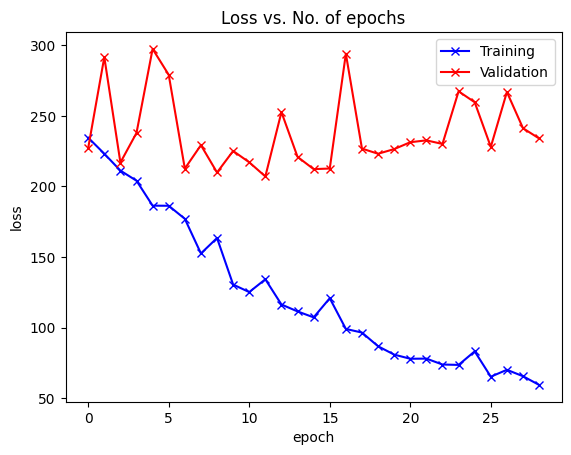

In [101]:
#plot_accuracies(history)
plot_losses(history)

In [ ]:
# do the training
'''num_epochs = 10

H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    validation_loss = 0.0

    train_correct = 0
    validation_correct = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        inputs = inputs.permute(0, 3, 1, 2)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()'''
'''
        running_loss += loss.item()

    # Print average loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_dataloader):.4f}")'''

In [ ]:
'''# do the evaluation
model.eval()
total_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.permute(0, 3, 1, 2)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        total_loss += loss.item()

    average_loss = total_loss / len(test_dataloader)
    print(f"Test Loss: {average_loss:.4f}")'''

In [ ]:
# some weird problems with this architecture from (https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/)
'''class LeNet(nn.Module):
    def __init__(self, numChannels):
		    # call the parent constructor
		    super(LeNet, self).__init__()
		    # initialize first set of CONV => RELU => POOL layers
		    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
		    self.relu1 = nn.ReLU()
		    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		    # initialize second set of CONV => RELU => POOL layers
		    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
		    self.relu2 = nn.ReLU()
		    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		    # initialize first (and only) set of FC => RELU layers
		    self.fc1 = nn.Linear(in_features=800, out_features=500)
		    self.relu3 = nn.ReLU()
		    # initialize our softmax classifier
		    self.fc2 = nn.Linear(in_features=500, out_features=1)
		    self.logSoftmax = nn.LogSoftmax(dim=1)
  
    def forward(self, x):
		    # pass the input through our first set of CONV => RELU =>
		    # POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = nn.flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output'''